In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Loader**

---



In [ ]:
''' Split for number of classes in training and test '''
num_sampleclasses = 7
num_fewshotclasses = 3 #atleast two

''' Number of audio-label pairs in Training (sample) and Test (fewshot) '''
sample_train = 600
sample_val = 0
sample_test = 0

fewshot_train = 0
fewshot_val = 60
fewshot_test = 200

''' Audio to STFT hyperparameters '''
sampling_rate = 44100
row_len = 513 # Number of columns: 1 + n_fft/2
col_len = 401 # Number of rows: 1 + (sampling_rate*audio_duration)/(0.01*sampling_rate); 0.01*sampling_rate = hop 
# audio_length = sampling_rate*audio_duration
# audio_duration = 4 seconds

In [ ]:
%cd "/content/drive/MyDrive/DCASE-task1"

/content/drive/MyDrive/DCASE-task1


In [ ]:
import numpy as np
import pandas as pd

import math
import random
import matplotlib.pyplot as plt

import librosa

from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler

Number of audio-label pairs for each class. Clearly, *car horn* and *gun shot* are *rare classes*. We will always include them in test dataset. 


The third class for the test set in selected randomly. *FEWSHOT_CLASSES* are test set classes and *SAMPLE_CLASSES* are training set classes.

In [ ]:
df = pd.read_csv("dcase1.csv")
df["class"].value_counts()

metro_station        2304
street_pedestrian    2304
park                 2304
street_traffic       2304
bus                  2304
metro                2304
public_square        2303
shopping_mall        2303
tram                 2303
airport              2302
Name: class, dtype: int64

In [ ]:
CLASSES = list(df["class"].unique())

random.shuffle(CLASSES)
SAMPLE_CLASSES = CLASSES[:num_sampleclasses]
FEWSHOT_CLASSES = CLASSES[num_sampleclasses:]

print(SAMPLE_CLASSES, FEWSHOT_CLASSES)

['street_pedestrian', 'bus', 'park', 'tram', 'shopping_mall', 'metro_station', 'metro'] ['street_traffic', 'airport', 'public_square']


In [ ]:
def get_data(class_name, n_train, n_val, n_test):
    df_class = df.loc[df["class"] == class_name]
    indexes = [i for i in range(df_class.shape[0])]
    random.shuffle(indexes)

    df_class_train = df_class.iloc[indexes[:n_train]]
    df_class_val = df_class.iloc[indexes[n_train:(n_train + n_val)]]
    df_class_test = df_class.iloc[indexes[(n_train + n_val):(n_train + n_val + n_test)]]

    return df_class_train, df_class_val, df_class_test

In [ ]:
SAMPLE_data_train = [None]*num_sampleclasses
SAMPLE_data_val = [None]*num_sampleclasses
SAMPLE_data_test = [None]*num_sampleclasses

for i in range(num_sampleclasses):
    SAMPLE_data_train[i], SAMPLE_data_val[i], SAMPLE_data_test[i] = get_data(SAMPLE_CLASSES[i], sample_train, sample_val, sample_test)

FS_data_train = [None]*num_fewshotclasses
FS_data_val = [None]*num_fewshotclasses
FS_data_test = [None]*num_fewshotclasses

for i in range(num_fewshotclasses):
    FS_data_train[i], FS_data_val[i], FS_data_test[i] = get_data(FEWSHOT_CLASSES[i], fewshot_train, fewshot_val, fewshot_test)

In [ ]:
df_train = pd.concat((SAMPLE_data_train + FS_data_train), ignore_index = True)
df_val = pd.concat((SAMPLE_data_val + FS_data_val), ignore_index = True)
df_test = pd.concat((SAMPLE_data_test + FS_data_test), ignore_index = True)

So far, we have randomly selected
 

*   600 (*sample_train*) audio-label pairs per class for training dataset.
*   20 (*fewshot_val*) audio-label pairs per class for validation dataset.
*   200 (*fewshot_test*) audio-label pairs per class for test dataset.

In [ ]:
print(list(df_train["class"].value_counts()))
print(list(df_val["class"].value_counts()))
print(list(df_test["class"].value_counts()))

[600, 600, 600, 600, 600, 600, 600]
[60, 60, 60]
[200, 200, 200]


In [ ]:
# df_train.to_csv("", index = False)
# df_val.to_csv("", index = False)
# df_test.to_csv("", index = False)

In [ ]:
df_tmp = pd.read_csv("dcase1.csv")
_labels = list(df_tmp["class"].unique())
label_idx = {label: i for i, label in enumerate(_labels)}
n_classes = len(df_tmp["class"].unique())

**Divide each of train, validation and test into smaller DataFrames for Few-Shot learning**

In [ ]:
def CreatDataFolders(df, n, samples, per_df):
    df["label_idx"] = df["class"].apply(lambda x : label_idx[x])
    df.sort_values(by = "label_idx", inplace = True)

    a = 0
    b = per_df
    dfs = []
    for _ in range(n):
        tmp = []
        for i in range(int(samples/per_df)):
            tmp.append(df.iloc[a:b])
            a += per_df
            b += per_df
        dfs.append(tmp)
    
    return dfs

In [ ]:
dfs_train = CreatDataFolders(df_train, num_sampleclasses, sample_train, 30)
dfs_val = CreatDataFolders(df_val, num_fewshotclasses, fewshot_val, 20)
dfs_test = CreatDataFolders(df_test, num_fewshotclasses, fewshot_test, 20)

# **Utility Functions**

---

In [ ]:
def wav2feat(wavfile, Fs = sampling_rate):
    ''' input: file path to an audio file (.wav file)
        output: padded STFT '''
        
    x, _ = librosa.core.load(wavfile, sr = Fs, mono = True)
    hop = int(0.01*Fs) # 10ms
    win = int(0.02*Fs) # 20ms
    X = librosa.stft(x, n_fft = 1024, hop_length = hop, win_length = win, window = 'hann', center = True, pad_mode = "reflect")
    X = np.abs(X)

    if X.shape[1] > col_len:
        max_offset = X.shape[1] - col_len
        offset = np.random.randint(max_offset)
        X = X[:, offset : (col_len + offset)]
    else:
        if X.shape[1] < col_len:
            max_offset = col_len - X.shape[1]
            offset = np.random.randint(max_offset)
        else:
            offset = 0
        X = np.pad(X, ((0, 0), (offset, col_len - X.shape[1] - offset)), "constant")

    return X

In [ ]:
class DCASE1Task(object):
    ''' "num_classes is no. of classes per episode randomly
        selected from the pool of train classes.
        "train_num"/"test_num" is number of samples per class. '''

    def __init__(self, num_classes = 3, train_num = 5, test_num = 15, dfs = None, split ='train'):
        self.num_classes = num_classes
        self.train_num = train_num
        self.test_num = test_num
        self.dfs = dfs
        self.mode = split

        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_labels = []
        self.test_labels = []

        if (self.mode == 'train'):
            sample_idx = random.sample([i for i in range(num_sampleclasses)], self.num_classes)
        else:
            sample_idx = random.sample([i for i in range(num_fewshotclasses)], self.num_classes)

        list_dfs = []
        for idx in sample_idx:
            list_dfs.append(random.sample(self.dfs[idx], 1))
        
        for i, df in enumerate(list_dfs):
            df = shuffle(df[0])
            self.train = self.train.append(df[:train_num])
            self.train_labels.extend([i for j in range(train_num)])

            self.test = self.test.append(df[train_num:(train_num + test_num)])
            self.test_labels.extend([i for j in range(test_num)])

In [ ]:
class FewShotDataset(Dataset):
    ''' It is a custom pytorch Dataset.
        input: An object of "DCASE1Task" class. '''

    def __init__(self, task, split = 'train'):
        self.task = task
        self.mode = split
        self.df = self.task.train if self.mode == 'train' else self.task.test
        self.labels = self.task.train_labels if self.mode == 'train' else self.task.test_labels

    def __len__(self):
        return len(self.df.shape[0])

    def __getitem__(self, idx):
        raise NotImplementedError("WRONG CLASS INSTANT.")

In [ ]:
class DCASE1Data(FewShotDataset):
    ''' The Dataset class. The __getitem__ function returns an
        STFT-label pair when we pass an index of the DataFrame. '''

    def __init__(self, *args, **kwargs):
        super(DCASE1Data, self).__init__(*args, **kwargs)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        index = int(idx)
        fname = self.df['file_name'].iloc[index]
        STFT = wav2feat(fname)
        STFT = np.expand_dims(STFT, axis = -1)
        
        return torch.transpose(torch.from_numpy(STFT), 0, 2), self.labels[index]

In [ ]:
class ClassBalancedSampler(Sampler):
    ''' A custom pytorch sampler. It samples "num_inst" examples for each of
        "num_cl" classes. "num_per_class" is the number of examples present in
        the current DataFrame. It reults a list of indexes. '''

    def __init__(self, num_per_class, num_cl, num_inst,shuffle=True):
        self.num_per_class = num_per_class
        self.num_cl = num_cl
        self.num_inst = num_inst
        self.shuffle = shuffle

    def __iter__(self):
        if self.shuffle:
            batch = [[i+j*self.num_inst for i in torch.randperm(self.num_inst)[:self.num_per_class]] for j in range(self.num_cl)]
        else:
            batch = [[i+j*self.num_inst for i in range(self.num_inst)[:self.num_per_class]] for j in range(self.num_cl)]
        batch = [item for sublist in batch for item in sublist]

        if self.shuffle:
            random.shuffle(batch)
        return iter(batch)

    def __len__(self):
        return 1

In [ ]:
def get_data_loader(task, num_per_class = 1, split = 'train', shuffle = True):
    ''' The Dataloader function. "num_per_class" is the number
        of STFT-label pairs per class for train/test. '''

    dataset = DCASE1Data(task, split = split)

    if split == 'train':
        sampler = ClassBalancedSampler(num_per_class, task.num_classes, task.train_num, shuffle = shuffle)
    else:
        sampler = ClassBalancedSampler(num_per_class, task.num_classes, task.test_num, shuffle = shuffle)
    loader = DataLoader(dataset, batch_size = num_per_class*task.num_classes, sampler = sampler)

    return loader

# **Training**

---



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda


In [ ]:
!nvidia-smi

Tue May 11 13:06:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
''' 3 way 5 shot'''
CLASS_NUM = 3
SAMPLE_NUM_PER_CLASS = 5
BATCH_NUM_PER_CLASS = 15 # equivalent to number of test samples

FEATURE_DIM = 64 # the depth of CNN encoder
INPUT_SIZE = 1536
RELATION_DIM = 8

EPISODE = 5000
TEST_EPISODE = 100

LEARNING_RATE = 0.01

In [ ]:
class CNNEncoder(nn.Module):
    ## the encoder module as explained in the paper, consists of 4 "convolution-batchnorm-relu-maxpool" blocks
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 0),
                        nn.BatchNorm2d(64, momentum = 1, affine = True),
                        nn.ReLU(),
                        nn.MaxPool2d(4))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size = 5, stride = 1, padding = 0),
                        nn.BatchNorm2d(64, momentum = 1, affine = True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 0),
                        nn.BatchNorm2d(64, momentum = 1, affine = True),
                        nn.ReLU())
        self.layer4 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 0),
                        nn.BatchNorm2d(64, momentum = 1, affine = True),
                        nn.ReLU())

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

class RelationNetwork(nn.Module):
   ## the relation network module as explained in the paper
    def __init__(self, input_size, hidden_size):
        super(RelationNetwork, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(128, 64, kernel_size = 3, padding = 1),
                        nn.BatchNorm2d(64, momentum = 1, affine = True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
                        nn.BatchNorm2d(64, momentum = 1, affine = True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = torch.sigmoid(self.fc2(out))
        return out

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm') != -1:
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        n = m.weight.size(1)
        m.weight.data.normal_(0, 0.01)
        m.bias.data = torch.ones(m.bias.data.size())

In [ ]:
train_losses = [] ## list to keep check on losses
def train(): 
    ##function to initialise and train an entire pipeline end to end. 
    ## arguments: None
    ## returns the trained encoder and relation networks
    ## initialise the embedding and relation network modules
    feature_encoder = CNNEncoder()
    relation_network = RelationNetwork(INPUT_SIZE, RELATION_DIM)

    feature_encoder.apply(weights_init)
    relation_network.apply(weights_init)

    feature_encoder.cuda(device)
    relation_network.cuda(device)

    ## initialising the optimizers for the modules

    feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(), lr = LEARNING_RATE)
    feature_encoder_scheduler = StepLR(feature_encoder_optim, step_size = 10, gamma = 0.9)

    relation_network_optim = torch.optim.Adam(relation_network.parameters(), lr = LEARNING_RATE)
    relation_network_scheduler = StepLR(relation_network_optim, step_size = 10, gamma = 0.9)

    last_loss = 100.0
    counter = 0
    feature_encoder.zero_grad()
    relation_network.zero_grad()

    for episode in range(EPISODE):

        task = DCASE1Task(num_classes = CLASS_NUM, train_num = SAMPLE_NUM_PER_CLASS, test_num = BATCH_NUM_PER_CLASS, dfs = dfs_train)

        sample_dataloader = get_data_loader(task, num_per_class = SAMPLE_NUM_PER_CLASS, split = 'train', shuffle = False)
        batch_dataloader = get_data_loader(task, num_per_class = BATCH_NUM_PER_CLASS, split = 'test', shuffle = True)

        samples, sample_labels = sample_dataloader.__iter__().next()
        batches, batch_labels = batch_dataloader.__iter__().next()

        sample_features = feature_encoder(Variable(samples).cuda(device))
        sample_features = sample_features.view(CLASS_NUM, SAMPLE_NUM_PER_CLASS, FEATURE_DIM, sample_features.shape[-2], sample_features.shape[-1])

        sample_features = torch.sum(sample_features, 1).squeeze(1)
        batch_features = feature_encoder(Variable(batches).cuda(device))

        sample_features_ext = sample_features.unsqueeze(0).repeat(BATCH_NUM_PER_CLASS*CLASS_NUM, 1, 1, 1, 1)
        batch_features_ext = batch_features.unsqueeze(0).repeat(CLASS_NUM, 1, 1, 1, 1)
        batch_features_ext = torch.transpose(batch_features_ext, 0, 1)

        relation_pairs = torch.cat((sample_features_ext, batch_features_ext), 2).view(-1, FEATURE_DIM*2, sample_features.shape[-2], sample_features.shape[-1])
        relations = relation_network(relation_pairs).view(-1, CLASS_NUM)

        mse = nn.MSELoss().cuda(device)
        one_hot_labels = Variable(torch.zeros(BATCH_NUM_PER_CLASS*CLASS_NUM, CLASS_NUM).scatter_(1, batch_labels.view(-1, 1), 1)).cuda(device)
        loss = mse(relations, one_hot_labels)

        if ((episode + 1)%10 == 0):
            print("Episode", episode + 1 , "=  loss", loss.item())
        train_losses.append(loss.item())

        loss.backward()
        ## clipping gradient to stabilise training
        torch.nn.utils.clip_grad_norm_(feature_encoder.parameters(), 0.5)
        torch.nn.utils.clip_grad_norm_(relation_network.parameters(), 0.5)

        feature_encoder_optim.step()
        relation_network_optim.step()

        feature_encoder_scheduler.step(episode)
        relation_network_scheduler.step(episode)

        feature_encoder_optim.zero_grad()
        relation_network_optim.zero_grad()

        if last_loss > loss.item():
            torch.save(feature_encoder.state_dict(),str("feature_encoder_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) +"shot.pkl"))
            torch.save(relation_network.state_dict(),str("relation_network_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) +"shot.pkl"))

            last_loss = loss.item()
            print("\tSave Networks for episode =", episode + 1, "| Loss =", last_loss)
        else:
            counter += 1
            if (counter > 50):
                print("BREAKING")
                break

    return feature_encoder, relation_network

In [ ]:
feature_encoder, relation_network = train()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


	Save Networks for episode = 1 | Loss = 0.3826756775379181
	Save Networks for episode = 2 | Loss = 0.28079935908317566
	Save Networks for episode = 3 | Loss = 0.23981617391109467
	Save Networks for episode = 4 | Loss = 0.23790961503982544
	Save Networks for episode = 6 | Loss = 0.2235773354768753
	Save Networks for episode = 8 | Loss = 0.2212783694267273
Episode 10 =  loss 0.22811612486839294
	Save Networks for episode = 11 | Loss = 0.2201368510723114
	Save Networks for episode = 17 | Loss = 0.21396642923355103
Episode 20 =  loss 0.21504329144954681
	Save Networks for episode = 21 | Loss = 0.20793649554252625
	Save Networks for episode = 24 | Loss = 0.20714329183101654
	Save Networks for episode = 26 | Loss = 0.20014405250549316
Episode 30 =  loss 0.21371960639953613
	Save Networks for episode = 33 | Loss = 0.1889353096485138
	Save Networks for episode = 36 | Loss = 0.18848371505737305
	Save Networks for episode = 38 | Loss = 0.1790793538093567
	Save Networks for episode = 39 | Loss = 

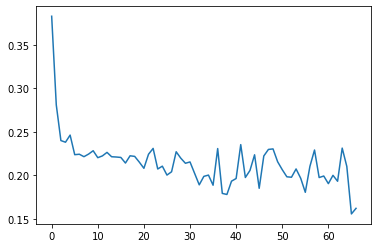

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

# **Test**

---



In [ ]:
feature_encoder = CNNEncoder()
relation_network = RelationNetwork(INPUT_SIZE, RELATION_DIM)

feature_encoder.apply(weights_init)
relation_network.apply(weights_init)

feature_encoder.cuda(device)
relation_network.cuda(device)

feature_encoder.load_state_dict(torch.load(str("feature_encoder_" + str(CLASS_NUM) +"way_" + str(SAMPLE_NUM_PER_CLASS) +"shot.pkl")))
relation_network.load_state_dict(torch.load(str("relation_network_"+ str(CLASS_NUM) +"way_" + str(SAMPLE_NUM_PER_CLASS) +"shot.pkl")))

<All keys matched successfully>

In [ ]:
total_rewards = 0.0
with torch.no_grad():
    for i in range(TEST_EPISODE):
        task = DCASE1Task(num_classes = CLASS_NUM, train_num = SAMPLE_NUM_PER_CLASS, test_num = BATCH_NUM_PER_CLASS, dfs = dfs_test, split = 'test')
        sample_dataloader = get_data_loader(task, num_per_class = SAMPLE_NUM_PER_CLASS, split = 'train', shuffle = False)
        batch_dataloader = get_data_loader(task, num_per_class = BATCH_NUM_PER_CLASS, split = 'test', shuffle = True)

        samples, sample_labels = sample_dataloader.__iter__().next()
        batches, batch_labels = batch_dataloader.__iter__().next()

        sample_features = feature_encoder(Variable(samples).cuda(device))
        sample_features = sample_features.view(CLASS_NUM, SAMPLE_NUM_PER_CLASS, FEATURE_DIM, sample_features.shape[-2], sample_features.shape[-1])
        sample_features = torch.sum(sample_features, 1).squeeze(1)
        batch_features = feature_encoder(Variable(batches).cuda(device))

        sample_features_ext = sample_features.unsqueeze(0).repeat(BATCH_NUM_PER_CLASS*CLASS_NUM, 1, 1, 1, 1)
        batch_features_ext = batch_features.unsqueeze(0).repeat(CLASS_NUM, 1, 1, 1, 1)
        batch_features_ext = torch.transpose(batch_features_ext, 0, 1)

        relation_pairs = torch.cat((sample_features_ext, batch_features_ext), 2).view(-1, FEATURE_DIM*2, sample_features.shape[-2], sample_features.shape[-1])
        relations = relation_network(relation_pairs).view(-1, CLASS_NUM)

        _, predict_labels = torch.max(relations.data, 1)

        rewards = [1 if predict_labels[j] == batch_labels[j] else 0 for j in range(CLASS_NUM*BATCH_NUM_PER_CLASS)]
        total_rewards += np.sum(rewards)

    test_accuracy = total_rewards/1.0/CLASS_NUM/BATCH_NUM_PER_CLASS/TEST_EPISODE

    print("test accuracy:", test_accuracy)

test accuracy: 0.46
